In [1]:
import pandas as pd
import numpy as np
import os 
import re
import operator
import nltk 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nvidia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv('../data/recipes/RAW_recipes.csv')

In [3]:
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
df.shape

(231637, 12)

In [5]:
df = df.dropna()
df.shape

(226657, 12)

## Exploring Tags

In [6]:
from ast import literal_eval
df['arr_tags'] = df['tags'].apply(lambda x: literal_eval(str(x)))

In [7]:
text = ""
for tag_array in df.arr_tags:
    for word in tag_array:
        curr_word = word.replace('-', '_')
        text += ' ' + curr_word

In [8]:
text[0:100]

' 60_minutes_or_less time_to_make course main_ingredient cuisine preparation occasion north_american '

In [13]:
text_set = set()
text_array = text.split(' ')

for tag in text_array:
    text_set.add(tag)

In [14]:
print(text_set)

{'', 'lime', 'hanukkah', 'mothers_day', 'caribbean', 'easy', 'main_dish', 'chowders', 'apples', 'mango', 'pheasant', 'fish', 'Food.com.', 'pork', 'fathers_day', 'beginner_cook', 'fruit', 'mushroom_soup', 'omelets_and_frittatas', 'beef_crock_pot', 'romantic', 'hidden_valley_ranch', 'elk', 'papaya', 'thanksgiving', 'lactose', 'broccoli', 'nepalese', 'christmas', 'hawaiian', 'chicken_livers', 'sweet_sauces', 'austrian', 'jams_and_preserves', 'dehydrator', 'meat', 'infant_baby_friendly', 'palestinian', 'scallops', 'less_thansql:name_topics_of_recipegreater_than', 'american', 'egg_free', 'meatballs', 'oaxacan', 'manicotti', 'italian', 'crock_pot_main_dish', 'very_low_carbs', 'mahi_mahi', 'african', 'oranges', 'smoker', 'bass', 'from_scratch', 'gelatin', 'central_american', 'saltwater_fish', 'appetizers', 'lunch', 'cuisine', 'baked_beans', 'bean_soup', 'coffee_cakes', 'lebanese', 'yams_sweet_potatoes', 'pizza', 'irish', 'chocolate', 'ragu_recipe_contest', 'pumpkin_bread', 'comfort_food', 'ha

In [1]:
from collections import Counter
tag_count = Counter(text_array)
# tag_count.most_common()

NameError: name 'text_array' is not defined

In [11]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Import package
from wordcloud import WordCloud, STOPWORDS

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

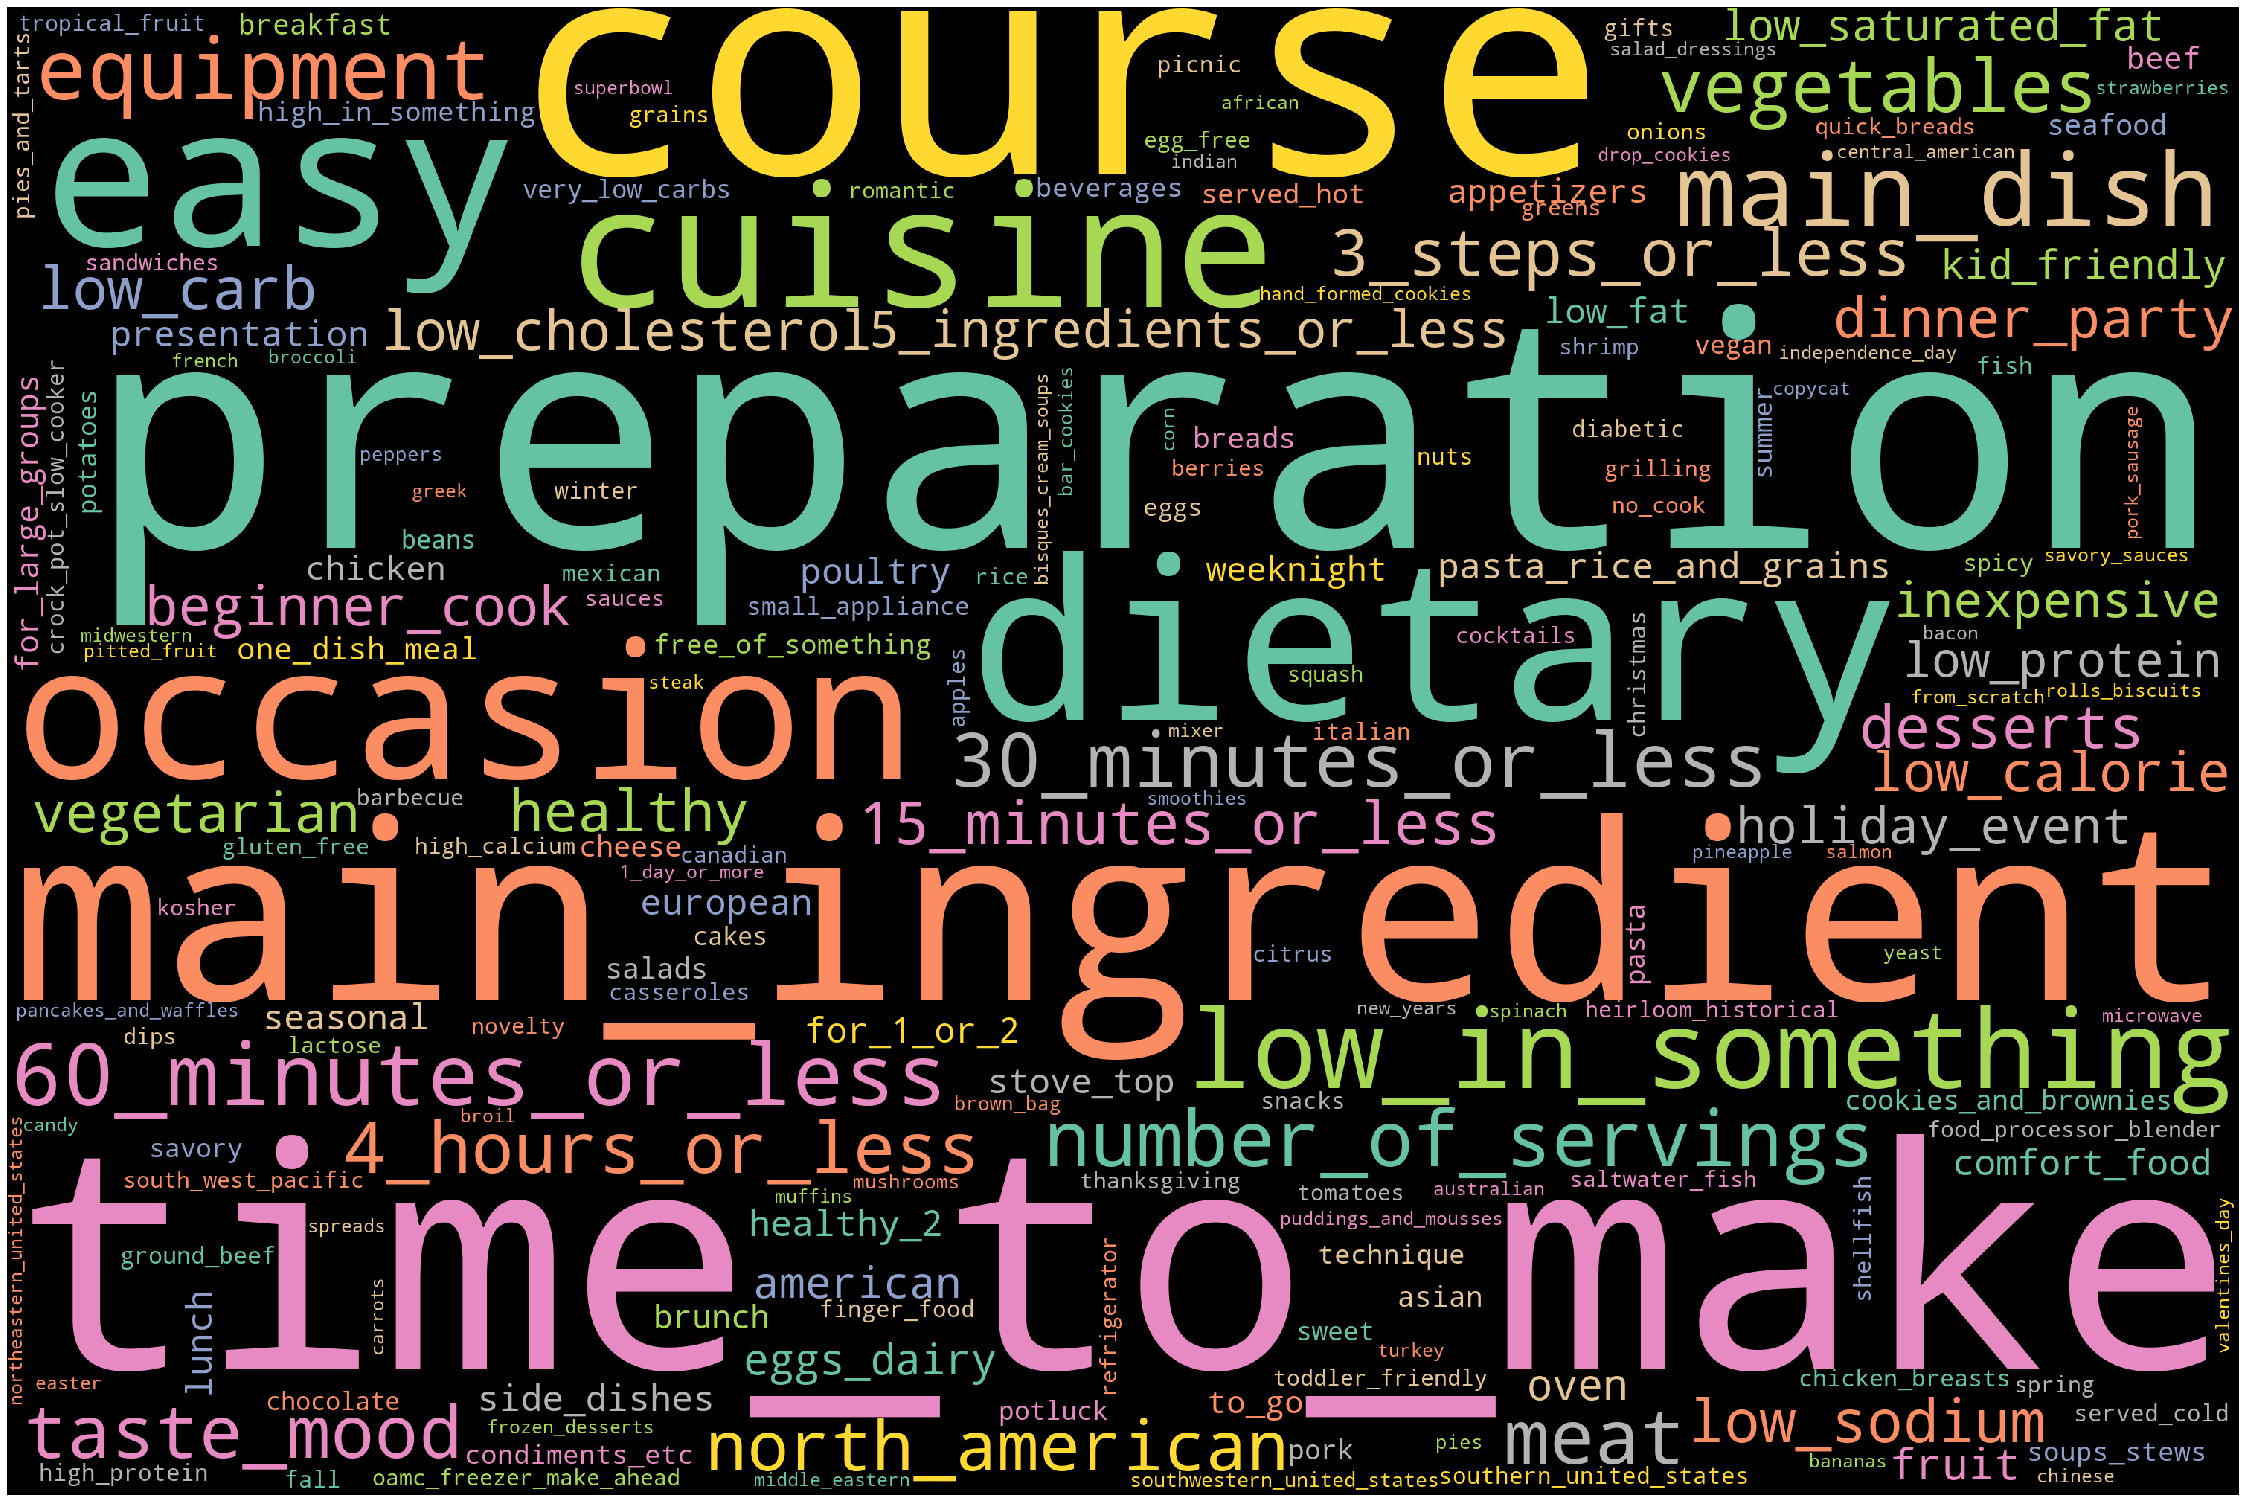

In [12]:
# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

## TFIDF

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()
for doc in df.name:
    try:
        vocabulary.update(doc.split(' '))
    except:
        print(doc)
vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary)
# Fit the TfIdf model
tfidf.fit(df.name)
# Transform the TfIdf model
tfidf_tran=tfidf.transform(df.name)

In [78]:
def gen_vector_T(tokens):
    Q = np.zeros((len(vocabulary)))    
    x= tfidf.transform(tokens)
    # print(tokens[0].split(','))
    for token in tokens[0].split(','):
        # print(token)
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

In [79]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [82]:
def cosine_similarity_T(k, query):
    preprocessed_query = preprocessed_query = re.sub("\W+", " ", query).strip()
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    a = pd.DataFrame()
    for i,index in enumerate(out):
        try:
            a.loc[i,'index'] = str(index)
            a.loc[i,'name'] = df['name'][index]
        except:
            pass
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

In [83]:
cosine_similarity_T(10,"hot soup")


,index,name,Score
0,124806,linguini with white clam sauce,0.816497
1,1398,31st year meatloaf,0.816497
2,203091,summer frappe low fat,0.816497
3,11525,awesome carrot cake,0.750000
4,87434,fresh chunky cranberry sauce,0.707107
5,106445,homemade chocolate syrup,0.707107
6,106837,homemade sausage rolls,0.707107
7,106384,homemade canadian bacon,0.707107
8,106789,NaN,0.707107
9,146720,okra on the side,0.707107


Really bad results... trying bag of words instead

## Simple Search

In [2]:
df = pd.read_csv('../data/recipes/RAW_recipes.csv')
df = df.dropna()
df['tags'] = df['tags'].apply(lambda x: literal_eval(str(x)))
df['ingredients'] = df['ingredients'].apply(lambda x: literal_eval(str(x)))
df['steps'] = df['steps'].apply(lambda x: literal_eval(str(x)))

In [3]:
query = "sweet potato"

search_list = query.split(" ")

data_new = df.copy()

for search in search_list:            
    data_new = data_new[data_new.name.str.contains(search)]

print('related recipes: {}'.format(data_new.shape[0]))
data_new.head()

related recipes: 1627


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
462,missy s sweet potato casserole,401605,50,814629,2009-11-28,"[60-minutes-or-less, time-to-make, course, mai...","[548.5, 41.0, 212.0, 8.0, 11.0, 56.0, 24.0]",7,"[preheat oven to 350 degrees, mash the sweet p...",this is the recipe i have been using for years...,"[cooked sweet potatoes, sugar, butter, eggs, m...",10
481,not too sweet sweet potatoes,196006,53,169341,2006-11-18,"[60-minutes-or-less, time-to-make, course, mai...","[604.9, 21.0, 124.0, 3.0, 11.0, 42.0, 39.0]",8,[roast yams / sweet potatoes @ 375 for 45 minu...,if you don't like your yams or sweet potatoes ...,"[yams, unsalted butter, dark brown sugar, hone...",8
1394,30 minute seasoned sweet potato yam fries b...,406737,30,1375473,2010-01-04,"[30-minutes-or-less, time-to-make, course, mai...","[118.1, 10.0, 11.0, 6.0, 2.0, 4.0, 4.0]",8,[scrub the sweet potatoes and leave the skin o...,perfectly zesty sweet potato fries to accompan...,"[sweet potatoes, olive oil, paprika, cinnamon,...",6
2048,a really good sweet potato recipe,146992,120,245037,2005-12-01,"[time-to-make, course, preparation, occasion, ...","[634.9, 59.0, 192.0, 10.0, 12.0, 91.0, 23.0]",6,"[beat eggs , stir in potatoes until blended, a...",this always gets rave reviews when i make it f...,"[eggs, sweet potatoes, sugar, butter, heavy cr...",11
2071,a simple sweet potato fritters recipe from sou...,309827,25,527607,2008-06-17,"[30-minutes-or-less, time-to-make, preparation...","[115.2, 1.0, 13.0, 2.0, 6.0, 1.0, 7.0]",8,[heat 2 inches of oil in a heavy saucepan or f...,"found on big oven, posted for zwt","[peanut oil, egg, sweet potato, salt, flour]",5


In [4]:
tags = "30-minutes-or-less 60-minutes-or-less"

search_list = tags.split(" ")

data_new = df.copy()

# for search in search_list:            
mask = df.tags.apply(lambda x: any(i in search_list for i in x))
    # mask = df.tags.apply(lambda x: search in x)
data_new = df[mask]
    # data_new = data_new[search in data_new.tags]

print('related recipes: {}'.format(data_new.shape[0]))
data_new.head()

related recipes: 122689


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
16,chile rellenos,43026,45,52268,2002-10-14,"[60-minutes-or-less, time-to-make, course, mai...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"[drain green chiles, sprinkle cornstarch on sh...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5
20,cream of spinach soup,76808,45,95743,2003-11-17,"[60-minutes-or-less, time-to-make, course, mai...","[126.0, 11.0, 2.0, 14.0, 5.0, 23.0, 4.0]",9,"[bring water and salt to a boil, cut the potat...","wonderful comfort food from rozanne gold, a fa...","[water, salt, boiling potatoes, fresh spinach ...",8


In [7]:
data_new.loc[data_new['minutes'] == 30].sample(n=3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
128592,maids of honour old english tudor cheesecakes,216860,30,242729,2007-03-14,"[30-minutes-or-less, time-to-make, course, mai...","[369.8, 36.0, 36.0, 5.0, 15.0, 26.0, 11.0]",8,[pre-heat oven to 220c / 450f / gas7 and light...,these are the forerunner of modern baked chees...,"[puff pastry, curd cheese, soft brown sugar, e...",10
114507,japanese style beef rib eye bbq beef yakiniku,305016,30,61569,2008-05-27,"[30-minutes-or-less, time-to-make, course, mai...","[558.8, 61.0, 54.0, 65.0, 49.0, 61.0, 6.0]",7,[slice beef rib eye roast or prime rib into ap...,this is the second recipe for the japanese sty...,"[beef rib eye roast, soy sauce, sake, sesame o...",9
183283,seafood pinwheels with havarti sauce,28300,30,30534,2002-05-13,"[30-minutes-or-less, time-to-make, course, mai...","[278.0, 17.0, 0.0, 15.0, 80.0, 30.0, 0.0]",8,"[preheat oven to 450f, season fillets with sal...",a simple and elegant way to prepare fillets of...,"[sole fillets, salt, white pepper, lemon, juic...",8


In [8]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))

from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

Porter Stemmer
cat
troubl
troubl
troubl


In [13]:
stemSentence('mushrooms, peaches, cauliflower, pasta, eggs, and rices')

'mushroom , peach , cauliflow , pasta , egg , and rice , strawberri '